In [114]:
%load_ext autoreload
%autoreload 

import matplotlib.pyplot as plotter_lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
%matplotlib inline
import os
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageOps

In [15]:
df_train = pd.read_csv('raw_data/sign_mnist_train.csv')
df_test = pd.read_csv('raw_data/sign_mnist_test.csv')
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

In [47]:
### Fake the datasets for ResN50 pre-trained model
def image_padding(X_train, input_d1=28, input_d2=28, out_d1=32, out_d2=32):
    X_train_gray = np.array(X_train).reshape(-1, input_d1, input_d2)
    print(X_train_gray.shape)
    X_train_rgb = []
    for i in range(len(X_train_gray)): 
        new_image = np.vstack((np.hstack((X_train_gray[i], np.ones((input_d1,out_d2-input_d2))*255)),
                               np.ones((out_d1-input_d1, out_d2))*255))
        new_image = Image.fromarray(new_image).convert('RGB')
        X_train_rgb.append(np.array(new_image))
    return np.array(X_train_rgb)

X_train_rgb = image_padding(X_train, 28, 28, 32, 32)
X_test_rgb = image_padding(X_test, 28, 28, 32, 32)

X_train_rgb.shape, X_test_rgb.shape

(27455, 28, 28)
(7172, 28, 28)


((27455, 32, 32, 3), (7172, 32, 32, 3))

In [60]:
y_train.shape, y_test.shape

((27455,), (7172,))

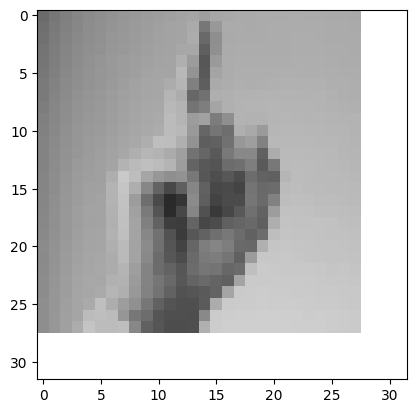

In [48]:
plt.imshow(X_train_rgb[0])

In [83]:
def initiliaze_model_vgg16():
    
    #Initialising vgg16 
    classifier_vgg16 = VGG16(input_shape= (32,32,3),include_top=False,weights='imagenet')
    
    #Don't train existing weights for vgg16
    for layer in classifier_vgg16.layers:
        layer.trainable = False
    
    #Add other layers for pre-trained model    
    classifier = classifier_vgg16.output #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dropout(0.6)(classifier)
    classifier = Dense(units=26, activation='softmax')(classifier)

    #Build & compile the model
    model = Model(inputs = classifier_vgg16.input , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [84]:
model = initiliaze_model_vgg16()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [93]:
def initialize_model_resn50():
    #Initialising ResNet50 
    classifier_resnet = tflow.keras.applications.ResNet50(input_shape= (32,32,3),include_top=False,weights='imagenet')
    
    #don't train existing weights for resnet50
    for layer in classifier_resnet.layers:
        layer.trainable = False
     
    #Add the necessary layers for pre-trained model   
    classifier = classifier_resnet.output #head mode
    classifier = Flatten()(classifier) #adding layer of flatten
    classifier = Dense(units=256, activation='relu')(classifier)
    classifier = Dropout(0.6)(classifier)
    classifier = Dense(units=26, activation='softmax')(classifier)

    #Build and compile the model
    model = Model(inputs = classifier_resnet.input , outputs = classifier)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [94]:
model2 = initialize_model_resn50()
model2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [87]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

y_train_ce = to_categorical(y_train, 26)
y_test_ce = to_categorical(y_test, 26)

X_train_scaled = X_train_rgb/255
X_test_scaled = X_test_rgb/255

X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_scaled, y_train_ce, test_size=0.2, stratify=y_train_ce)
X_train_f.shape, X_val_f.shape, y_train_f.shape, y_val_f.shape

((21964, 32, 32, 3), (5491, 32, 32, 3), (21964, 26), (5491, 26))

In [88]:
#fit the model and it will take some time to train
es = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train_f, y_train_f, epochs =15, batch_size = 64,validation_data=(X_val_f, y_val_f), callbacks=[es], verbose=1)

Epoch 1/15
344/344 [==============================] - 95s 274ms/step - loss: 1.7150 - accuracy: 0.4805 - val_loss: 0.8698 - val_accuracy: 0.7867
Epoch 2/15
344/344 [==============================] - 98s 286ms/step - loss: 0.8786 - accuracy: 0.7230 - val_loss: 0.5474 - val_accuracy: 0.8720
Epoch 3/15
344/344 [==============================] - 100s 290ms/step - loss: 0.6395 - accuracy: 0.8011 - val_loss: 0.4013 - val_accuracy: 0.8998
Epoch 4/15
344/344 [==============================] - 107s 312ms/step - loss: 0.4986 - accuracy: 0.8450 - val_loss: 0.2852 - val_accuracy: 0.9297
Epoch 5/15
344/344 [==============================] - 106s 309ms/step - loss: 0.3989 - accuracy: 0.8798 - val_loss: 0.2266 - val_accuracy: 0.9479
Epoch 6/15
344/344 [==============================] - 100s 290ms/step - loss: 0.3316 - accuracy: 0.9027 - val_loss: 0.1754 - val_accuracy: 0.9601
Epoch 7/15
344/344 [==============================] - 110s 319ms/step - loss: 0.2812 - accuracy: 0.9147 - val_loss: 0.1446 - v

In [101]:
def plot_loss_accuracy(history, suptitle):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=3)
    ax2.set_ylim(ymin=0, ymax=1)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')
    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)
    
    # Set supertitle
    plt.suptitle(suptitle)
    plt.show()
    
    return

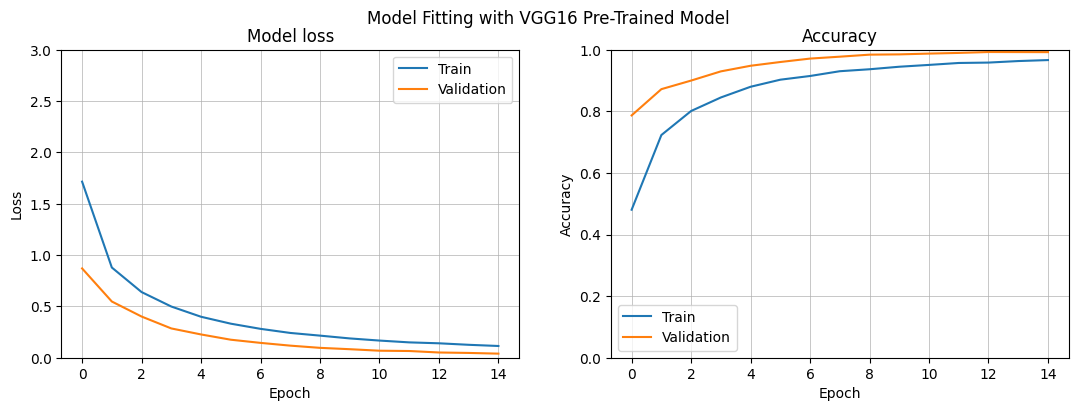

In [102]:
plot_loss_accuracy(history, "Model Fitting with VGG16 Pre-Trained Model")

In [91]:
score_vgg16 = model.evaluate(X_test_scaled, y_test_ce, verbose=1)
score_vgg16

225/225 [==============================] - 24s 106ms/step - loss: 0.2219 - accuracy: 0.9221


[0.2218780368566513, 0.9220579862594604]

In [97]:
#fit the model and it will take some time to train
history2 = model2.fit(X_train_f, y_train_f, epochs=15, batch_size=64,validation_data=(X_val_f, y_val_f), callbacks=[es], verbose=1)

Epoch 1/15
344/344 [==============================] - 64s 176ms/step - loss: 3.2302 - accuracy: 0.0517 - val_loss: 3.1022 - val_accuracy: 0.0954
Epoch 2/15
344/344 [==============================] - 64s 187ms/step - loss: 3.0769 - accuracy: 0.0733 - val_loss: 2.9626 - val_accuracy: 0.1604
Epoch 3/15
344/344 [==============================] - 67s 195ms/step - loss: 3.0251 - accuracy: 0.0849 - val_loss: 2.8938 - val_accuracy: 0.1947
Epoch 4/15
344/344 [==============================] - 64s 185ms/step - loss: 2.9797 - accuracy: 0.0919 - val_loss: 2.8553 - val_accuracy: 0.2087
Epoch 5/15
344/344 [==============================] - 66s 193ms/step - loss: 2.9555 - accuracy: 0.0958 - val_loss: 2.7660 - val_accuracy: 0.2515
Epoch 6/15
344/344 [==============================] - 60s 175ms/step - loss: 2.9356 - accuracy: 0.1002 - val_loss: 2.7860 - val_accuracy: 0.2440
Epoch 7/15
344/344 [==============================] - 62s 179ms/step - loss: 2.9051 - accuracy: 0.1021 - val_loss: 2.6407 - val_ac

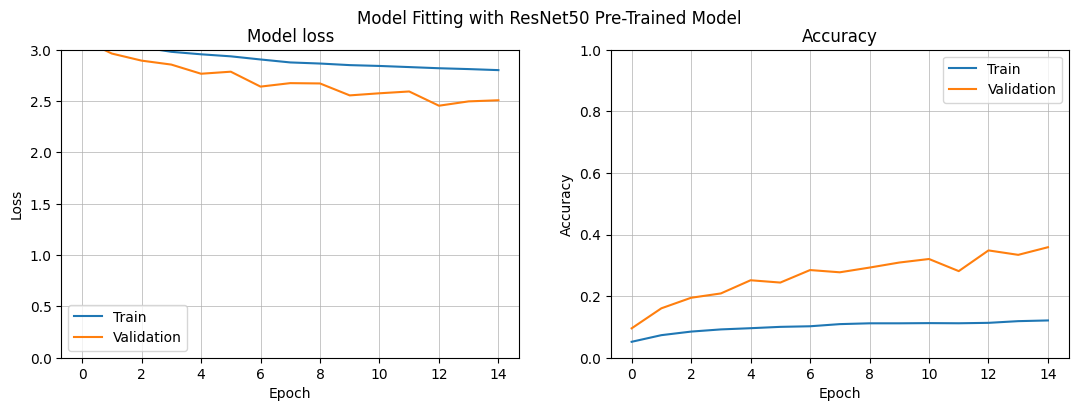

In [103]:
plot_loss_accuracy(history2, "Model Fitting with ResNet50 Pre-Trained Model")

In [107]:
score_resnet50 = model2.evaluate(X_test_scaled, y_test_ce, verbose=1)
score_resnet50

225/225 [==============================] - 19s 83ms/step - loss: 2.5830 - accuracy: 0.2575


[2.58301043510437, 0.25752928853034973]

In [108]:
models.save_model(model, "transfer_models/model_vgg16_v1")
# models.save_model(model2, "model_resnet50")

2023-05-23 15:42:32.291447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-23 15:42:33.193220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: transfer_models/model_vgg16_v1/assets


INFO:tensorflow:Assets written to: transfer_models/model_vgg16_v1/assets


In [121]:
from transfer_learning import Transfer_Model

model = Transfer_Model()
# y_pred = model.predict('raw_data/test/sign_mnist_test_v01.csv')
# y_pred

ImportError: cannot import name 'Transfer_Model' from 'transfer_learning' (/home/samgong/code/akurmankulov/sign-language-interpretation/transfer_learning.py)